<a href="https://www.kaggle.com/sammitjain/lok-sabha-questions-analysis-and-word-clouds?scriptVersionId=83338894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Check out the [description](https://github.com/sammitjain/loksabha-questions) for some more context about the datasets. I'm choosing to go with the flattened version for this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from statistics import mean
import textwrap

In [2]:
# Load the questions dataset
questions = pd.read_csv("/kaggle/input/lok-sabha-questions/questions_flattened.csv")

In [3]:
# General information
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 8035 non-null   int64 
 1   topic              8035 non-null   object
 2   from               8035 non-null   object
 3   to                 8035 non-null   object
 4   contents           8035 non-null   object
 5   date               8035 non-null   object
 6   type               8035 non-null   object
 7   party              8035 non-null   object
 8   state              8035 non-null   object
 9   constituency       8035 non-null   object
 10  constituency_type  1677 non-null   object
dtypes: int64(1), object(10)
memory usage: 690.6+ KB


In [4]:
# Each row stands for a "question". Check out the first 5 rows
questions.head()

,id,topic,from,to,contents,date,type,party,state,constituency,constituency_type
0,1,Centrally Sponsored Educational Institutes in ...,"Tadas, Shri Ramdas Chandrabhanji",EDUCATION,Will the Minister of EDUCATION be pleased to s...,2021-11-29,STARRED,Bharatiya Janata Party,Maharashtra,Wardha,NaN
1,1,Centrally Sponsored Educational Institutes in ...,"Sule, Smt. Supriya Sadanand",EDUCATION,Will the Minister of EDUCATION be pleased to s...,2021-11-29,STARRED,Nationalist Congress Party,Maharashtra,Baramati,NaN
2,2,Policy on Air Pollution,"Patil, Shri Bheemrao Baswanthrao","ENVIRONMENT, FOREST AND CLIMATE CHANGE","Will the Minister of ENVIRONMENT, FOREST AND C...",2021-11-29,STARRED,Telangana Rashtra Samithi,Telangana,Zahirabad,NaN
3,3,Ecological Sensitive Areas,"Kuriakose, Adv. Dean","ENVIRONMENT, FOREST AND CLIMATE CHANGE","Will the Minister of ENVIRONMENT, FOREST AND C...",2021-11-29,STARRED,Indian National Congress,Kerala,Idukki,NaN
4,4,Appointment of Directors in PSBs,"Syed Imtiaz Jaleel, Shri",FINANCE,Will the Minister of FINANCE be pleased to sta...,2021-11-29,STARRED,All India Majlis-E-Ittehadul Muslimeen,Maharashtra,Aurangabad,NaN


In [5]:
# Check number of rows and columns
print(f"There are {questions.shape[0]} rows and {questions.shape[1]} columns in this dataset")

There are 8035 rows and 11 columns in this dataset


In [6]:
# But these are not all unique questions. Check how many unique questions were presented
print(f"A total of {questions.contents.unique().shape[0]} unique questions were asked in the Lok Sabha from {questions.date.min()} to {questions.date.max()}")

A total of 4750 unique questions were asked in the Lok Sabha from 2021-11-29 to 2021-12-23


Let's see what a question looks like with proper formatting.

In [7]:
# Quick pretty print function to help with the formatting of a question

def pprint_question(question, width=80):
    if question.type=='STARRED':
        print(f"*Q.{question['id']}", end="")
    else:
        print(f"Q.{question['id']}", end="")
    print(question['date'].rjust(width, ' '))
    print(f"By: {question['from']}")
    print("")
    print(question['topic'].center(width, ' '))
    print("")
    contents = question['contents']
    contents = contents.replace('(a)','\n(a)').replace('(b)','\n(b)').replace('(c)','\n(c)').replace('(d)','\n(d)').\
                        replace('(e)','\n(e)').replace('(f)','\n(f)').replace('(g)','\n(g)').replace('(h)','\n(h)')
    contents_lines = contents.splitlines()
    for line in contents_lines:
        print(textwrap.fill(line, width=width))


# Printing the first question
pprint_question(questions.iloc[0])

*Q.1                                                                      2021-11-29
By: Tadas, Shri Ramdas Chandrabhanji

           Centrally Sponsored Educational Institutes in Maharashtra            

Will the Minister of EDUCATION be pleased to state:
(a) a comprehensive list of Centrally sponsored educational institutes
established in Maharashtra since the year 2014 containing the details such as
the courses offered, number of students studied every year, the number of
teaching faculty and non-teaching staff, etc. in each institute;
(b) the number of graduate students passed out from each institute along with
the total budget sanctioned and released for the overall development of these
institutes so far;
(c) whether the Union Government has not released the total sanctioned funds for
the purpose;
(d) if so, the details thereof along with the reasons therefor; and
(e) the appropriate steps taken or proposed to be taken by the Government to
release the rest of the funds for the ove

In [8]:
# Let's find out which MPs have been asking the most number of questions
questions_member_wise = questions.groupby('from')['from'].agg(['count']).sort_values('count', ascending=False).reset_index()
questions_member_wise.columns = ['MP', 'Number of Questions']
questions_member_wise

,MP,Number of Questions
0,"Bapat, Shri Girish Bhalchandra",53
1,"Majumdar, Dr. Sukanta",50
2,"Shewale, Shri Rahul Ramesh",50
3,"Sahu, Shri Chandra Sekhar",49
4,"Munde, Dr. Pritam Gopinath Rao",49
...,...,...
399,"Sarkar, Shri Jagannath",1
400,"Roy, Dr. Rajdeep",1
401,"Maurya, Dr. Sanghamitra",1
402,"Vasava, Shri Prabhubhai Nagarbhai",1


In [9]:
# Let's get some statistics on who asked the longest and shortest questions in the ongoing session
questions['Question Length'] = questions.contents.apply(len)
questions_length_wise = questions.sort_values('Question Length')[['from', 'id', 'date', 'type', 'topic', 'contents', 'Question Length']]
questions_length_wise

,from,id,date,type,topic,contents,Question Length
5532,"Margani, Shri Bharat Ram",2848,2021-12-15,UNSTARRED,Kotipali-Narasapuram Railway Line,Will the Minister of RAILWAYS be pleased to st...,161
7603,"Jayakumar, Dr. K.",4088,2021-12-22,UNSTARRED,Theft in Trains,Will the Minister of RAILWAYS be pleased to st...,167
7269,"Firojiya, Shri Anil",3862,2021-12-21,UNSTARRED,Panchayat System,Will the Minister of PANCHAYATI RAJ be pleased...,170
4425,"Sharma, Shri Jugal Kishore",2268,2021-12-10,UNSTARRED,Setting up of Yoga Kendras,Will the Minister of AYUSH be pleased to state...,181
4424,"Pathak, Smt. Riti",2268,2021-12-10,UNSTARRED,Setting up of Yoga Kendras,Will the Minister of AYUSH be pleased to state...,181
...,...,...,...,...,...,...,...
839,"Vijayakumar (Alias) Vijay Vasanth , Shri",410,2021-11-30,UNSTARRED,Losses due to Rains and Floods,Will the Minister of HOME AFFAIRS be pleased t...,1343
836,"Thirunavukkarasar, Shri Su.",410,2021-11-30,UNSTARRED,Losses due to Rains and Floods,Will the Minister of HOME AFFAIRS be pleased t...,1343
841,"Kirtikar, Shri Gajanan Chandrakant",410,2021-11-30,UNSTARRED,Losses due to Rains and Floods,Will the Minister of HOME AFFAIRS be pleased t...,1343
849,"Chellakumar, Dr. A.",410,2021-11-30,UNSTARRED,Losses due to Rains and Floods,Will the Minister of HOME AFFAIRS be pleased t...,1343


In [10]:
# What did these questions look like? Here's the shortest
pprint_question(questions_length_wise.iloc[0])

Q.2848                                                                      2021-12-15
By: Margani, Shri Bharat Ram

                       Kotipali-Narasapuram Railway Line                        

Will the Minister of RAILWAYS be pleased to state: the status of Kotipali-
Narasapuram railway line and the details of the cost and time overruns of this
project?


In [11]:
# And the longest one
pprint_question(questions_length_wise.iloc[-1])

Q.4121                                                                      2021-12-22
By: Singh, Shri Sushil Kumar

                     Cases of Cheating in Kendriya Bhandar                      

Will the PRIME MINISTER be pleased to state:
(a) whether some vendors of Kendriya Bhandar have cheated and caused pecuniary
loss to Kendriya Bhandar as stated by the OSD(vigilance) in the Office Order
No.KB/5/2020-Vig (Mis-3) dated 6.3.2020;
(b) if so, the details thereof and modus-operandi adopted by the said vendors of
Kendriya Bhandar;
(c) whether the said vendors who have cheated Kendriya Bhandar have been
identified and if so, the details thereof and the action taken against them;
(d) whether the vendor involved in cheating Kendriya Bhandar are still doing
business with Kendriya Bhandar and they visit Kendriya Bhandars head office
daily and are in constant touch with the management of Kendriya Bhandar;
(e) whether the Secretary(Personnel) CWO and CVO Kendriya Bhandar have received
comp

In [12]:
# Would be nice to see which MPs are more verbose and which ones more terse on average
def count_average_agg(q):
    names = {
        'Number of Questions': q.id.count(),
        'Average Question Length': q['Question Length'].mean()
    }
    return pd.Series(names, index=['Number of Questions', 'Average Question Length'])

questions.groupby('from').apply(count_average_agg).reset_index().sort_values('Average Question Length', ascending=False)

,from,Number of Questions,Average Question Length
263,"Rathod, Shri Ratansinh Magansinh",9.0,961.666667
308,"Selvam, Shri Ganesan",30.0,941.133333
247,"Premachandran, Shri N.K.",21.0,936.142857
147,"Kumar, Shri Dhanush M",40.0,932.475000
242,"Pon, Dr. Gautham Sigamani",36.0,930.861111
...,...,...,...
97,"Gogoi, Shri Topon Kumar",3.0,323.666667
387,"Vasava, Shri Prabhubhai Nagarbhai",1.0,312.000000
64,"Dabhi, Shri Bharatsinhji Shankarji",2.0,300.500000
270,"Rawat, Shri Tirath Singh",1.0,285.000000


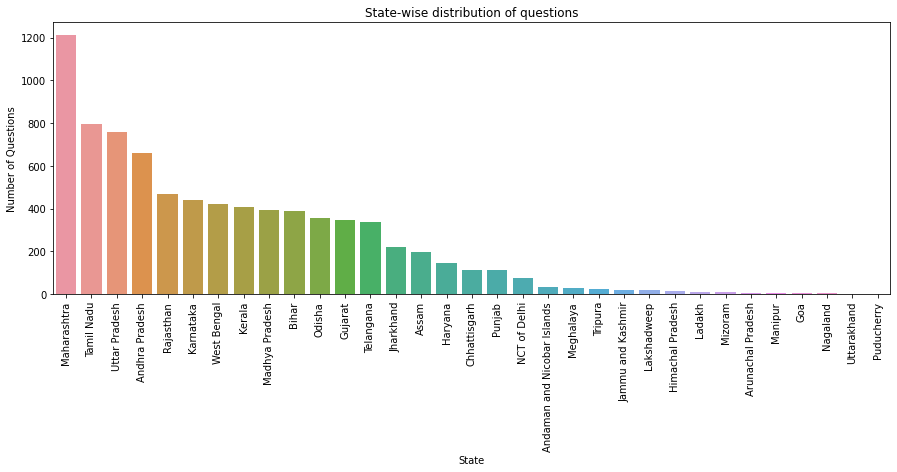

In [13]:
# Let's find out which state's MPs have been the most active
questions_state_wise = questions.groupby('state')['state'].agg(['count']).sort_values('count', ascending=False).reset_index()
questions_state_wise.columns = ['State', 'Number of Questions']
plt.figure(figsize=(15, 5))
plt.title('State-wise distribution of questions')
sns.barplot(x='State', y='Number of Questions', data=questions_state_wise)
plt.xticks(rotation=90)
plt.show()

In [14]:
# Are bigger states therefore more "active" in asking questions in the Lok Sabha?
# Not quite. Recall that not each state has an equal number of representatives in the Lok Sabha.
# Let's try to calculate the activity score of a state as : Number of questions from the state / Number of constituencies in the state

# Load members state, constituency info
members = pd.read_csv("/kaggle/input/lok-sabha-questions/members.csv")

# Find number of members from each State
state_counts = members.groupby('State')['State'].count().to_dict()

# Map state_counts to questions_state_wise
questions_state_wise['Number of MPs'] = questions_state_wise['State'].map(state_counts)

# Check out state wise questions now
questions_state_wise.head()

,State,Number of Questions,Number of MPs
0,Maharashtra,1211,48
1,Tamil Nadu,798,39
2,Uttar Pradesh,761,80
3,Andhra Pradesh,659,25
4,Rajasthan,468,25


In [15]:
questions_state_wise['State MP Activity Score'] = questions_state_wise['Number of Questions'] / questions_state_wise['Number of MPs']
questions_state_wise.head()

,State,Number of Questions,Number of MPs,State MP Activity Score
0,Maharashtra,1211,48,25.229167
1,Tamil Nadu,798,39,20.461538
2,Uttar Pradesh,761,80,9.512500
3,Andhra Pradesh,659,25,26.360000
4,Rajasthan,468,25,18.720000


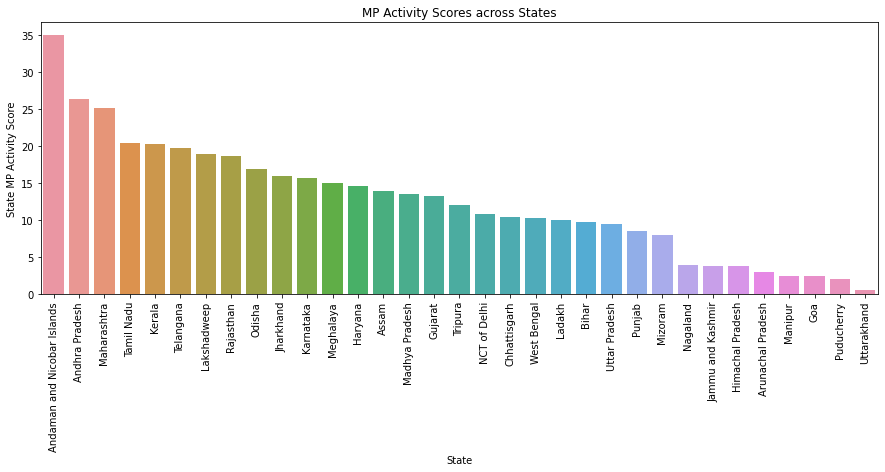

In [16]:
# Let's finally find out which state's MPs have been the most active
questions_state_wise = questions_state_wise.sort_values('State MP Activity Score', ascending=False)
plt.figure(figsize=(15, 5))
plt.title('MP Activity Scores across States')
sns.barplot(x='State', y='State MP Activity Score', data=questions_state_wise)
plt.xticks(rotation=90)
plt.show()

In [17]:
# What's up with Andaman and Nicobar Islands?
questions[questions['state']=='Andaman and Nicobar Islands'][['id', 'from', 'to', 'topic']]

,id,from,to,topic
41,5,"Sharma, Shri Kuldeep Rai","ENVIRONMENT, FOREST AND CLIMATE CHANGE",Ban on single use plastics
387,205,"Sharma, Shri Kuldeep Rai",EDUCATION,Shiksha Parv
417,210,"Sharma, Shri Kuldeep Rai",LABOUR AND EMPLOYMENT,India’s National Employment Policy
552,240,"Sharma, Shri Kuldeep Rai",AGRICULTURE AND FARMERS WELFARE,Crop Loss due to Heavy Rains and Floods
895,419,"Sharma, Shri Kuldeep Rai",SOCIAL JUSTICE AND EMPOWERMENT,Implementation of PM-DAKSH
902,421,"Sharma, Shri Kuldeep Rai",YOUTH AFFAIRS AND SPORTS,National Sports Awards
1094,491,"Sharma, Shri Kuldeep Rai","CONSUMER AFFAIRS, FOOD AND PUBLIC DISTRIBUTION",Data on Edible Oil
1133,517,"Sharma, Shri Kuldeep Rai",RAILWAYS,Enhance Freight Earnings
1229,592,"Sharma, Shri Kuldeep Rai",ELECTRONICS AND INFORMATION TECHNOLOGY,Digital Villages
1384,671,"Sharma, Shri Kuldeep Rai",TEXTILES,Comprehensive Handloom Cluster Development Scheme


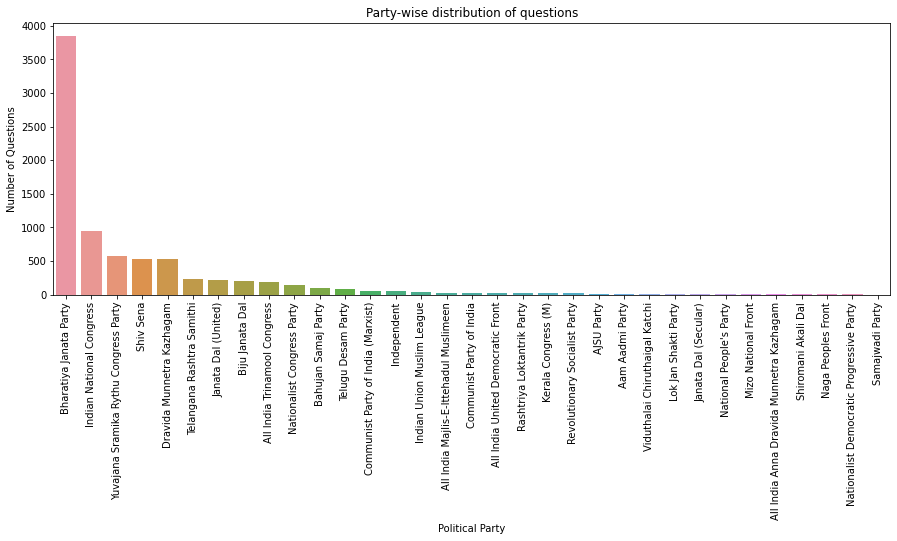

In [18]:
# Considering the political affiliation of the MPs, how many questions were contributed by members from a particular party?
questions_party_wise = questions.groupby('party')['party'].agg(['count']).sort_values('count', ascending=False).reset_index()
questions_party_wise.columns = ['Political Party', 'Number of Questions']
plt.figure(figsize=(15, 5))
plt.title('Party-wise distribution of questions')
sns.barplot(x='Political Party', y='Number of Questions', data=questions_party_wise)
plt.xticks(rotation=90)
plt.show()

In [19]:
# This graph isn't surprising. Need to formulate a Party MP Activity Score for better insights
# Find number of members from each Party
party_counts = members.groupby('Party')['Party'].count().to_dict()

# Map party_counts to questions_party_wise
questions_party_wise['Number of MPs'] = questions_party_wise['Political Party'].map(party_counts)

# Check out party wise questions now
questions_party_wise.head()

,Political Party,Number of Questions,Number of MPs
0,Bharatiya Janata Party,3849,301
1,Indian National Congress,951,53
2,Yuvajana Sramika Rythu Congress Party,582,22
3,Shiv Sena,537,19
4,Dravida Munnetra Kazhagam,529,24


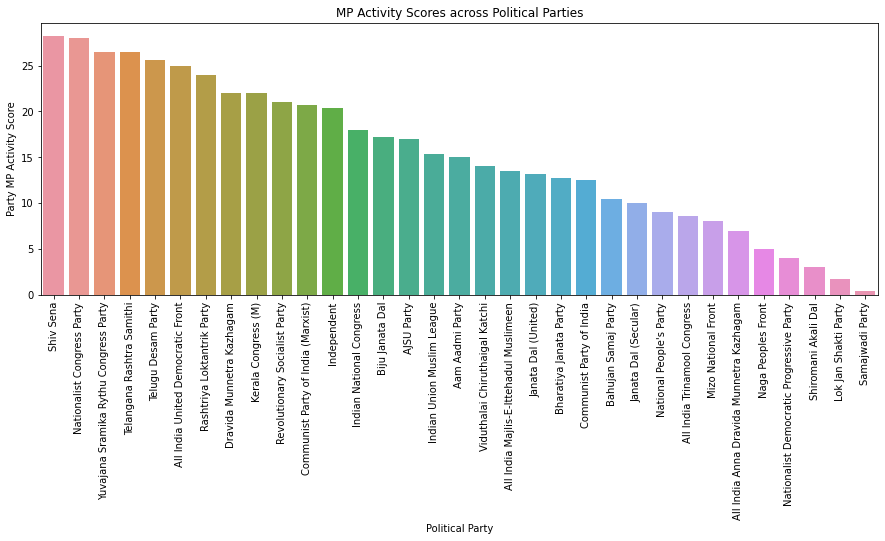

In [20]:
# Calculate Party MP Activity Score
questions_party_wise['Party MP Activity Score'] = questions_party_wise['Number of Questions'] / questions_party_wise['Number of MPs']

# Let's finally find out which party's MPs have been the most active
questions_party_wise = questions_party_wise.sort_values('Party MP Activity Score', ascending=False)
plt.figure(figsize=(15, 5))
plt.title('MP Activity Scores across Political Parties')
sns.barplot(x='Political Party', y='Party MP Activity Score', data=questions_party_wise)
plt.xticks(rotation=90)
plt.show()

## The curious case of Shri Sunil Kumars
* Mapping the Asking Member to an actual Member of Parliament was a difficult task. For e.g., consider the following names:
  - Shri Sunil Kumar Singh
  - Shri S.K. Singh
  - Shri Sunil Singh
  - *Singh, Shri Sunil Kumar*
  - Singh, Sunil Kumar
  - Singh, Sunil K.
* These are all valid ways to write a name. Which one do we stick to? I choose to go with the full name approach with Last Name, First Name. Fuzzy-matching of Indian names was a difficult task, but it worked out well, thanks mostly to [thefuzz](https://github.com/seatgeek/thefuzz).
* Btw, interestingly, we currently have *FIVE* Shri Sunil Kumar's as MPs:


| Member Name | Party | Constituency |
| --- | --- | --- |
| Mondal, Shri Sunil Kumar | All India Trinamool Congress	| Bardhaman Purba (SC)(West Bengal) |
| Singh, Shri Sunil Kumar	| Bharatiya Janata Party	| Chatra (Jharkhand) |
| Soni, Shri Sunil Kumar	| Bharatiya Janata Party	| Raipur (Chhattisgarh) |
| Sunil Kumar Pintu, Shri	| Janata Dal (United)	| Sitamarhi (Bihar) |
| Kumar, Shri Sunil	| Janata Dal (United)	| Valmiki Nagar (Bihar) |

* Would be interesting to see how all the Shri Sunil Kumars stack up against each other

In [21]:
# Collect all questions
questions_sunil = questions[questions['from'].str.contains('Sunil') & questions['from'].str.contains('Kumar')][['from', 'to', 'topic', 'contents']]
questions_sunil

,from,to,topic,contents
67,"Singh, Shri Sunil Kumar",CULTURE,Aazadi Ka Amrit Mahotsav,Will the Minister of CULTURE be pleased to sta...
256,"Soni, Shri Sunil Kumar",SKILL DEVELOPMENT AND ENTREPRENEURSHIP,Skill Loan Scheme,Will the Minister of SKILL DEVELOPMENT AND ENT...
325,"Sunil Kumar Pintu, Shri",LABOUR AND EMPLOYMENT,Labourers of Unorganised Sector,Will the Minister of LABOUR AND EMPLOYMENT be ...
738,"Singh, Shri Sunil Kumar",INFORMATION AND BROADCASTING,Celebration of Azadi Ka Amrit Mahotsava,Will the Minister of INFORMATION AND BROADCAST...
831,"Sunil Kumar Pintu, Shri",SOCIAL JUSTICE AND EMPOWERMENT,EWS in Bihar,Will the Minister of SOCIAL JUSTICE AND EMPOWE...
...,...,...,...,...
7578,"Singh, Shri Sunil Kumar",RAILWAYS,Railway Line Projects,Will the Minister of RAILWAYS be pleased to st...
7641,"Mondal, Shri Sunil Kumar",RAILWAYS,Development of Railways,Will the Minister of RAILWAYS be pleased to st...
7706,"Mondal, Shri Sunil Kumar","MICRO, SMALL AND MEDIUM ENTERPRISES",Schemes for MSMEs,"Will the Minister of MICRO, SMALL AND MEDIUM E..."
7836,"Singh, Shri Sunil Kumar",HOUSING AND URBAN AFFAIRS,Funds to Urban Local Bodies,Will the Minister of HOUSING AND URBAN AFFAIRS...


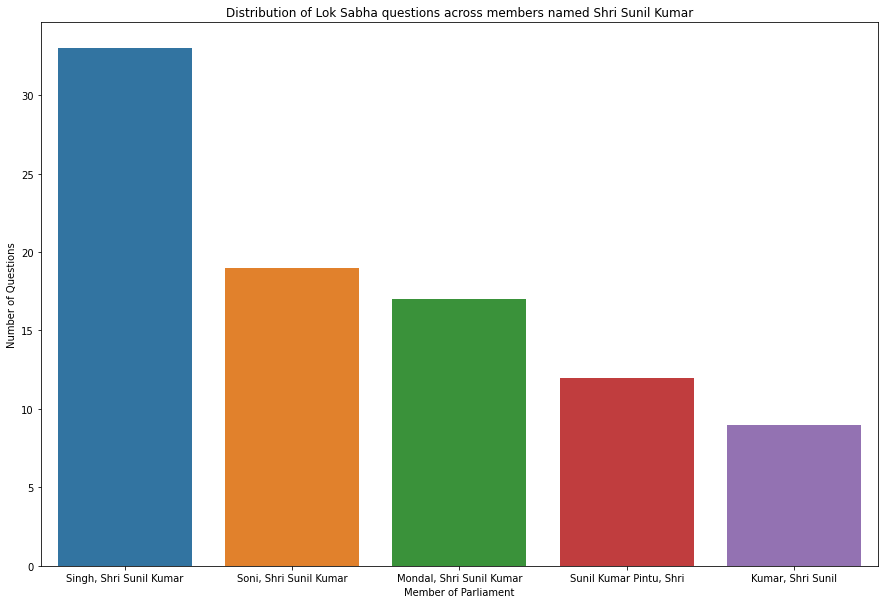

In [22]:
# Grouping these by 'from'
questions_sunil_wise = questions_sunil.groupby('from')['from'].agg(['count']).sort_values('count', ascending=False).reset_index()
questions_sunil_wise.columns = ['Member of Parliament', 'Number of Questions']
plt.figure(figsize=(15, 10))
plt.title('Distribution of Lok Sabha questions across members named Shri Sunil Kumar')
sns.barplot(x='Member of Parliament', y='Number of Questions', data=questions_sunil_wise)
plt.show()

In [23]:
# Here's a helper function for visualization of issues
from wordcloud import WordCloud, STOPWORDS

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

stopwords = set(STOPWORDS)
stopwords.update(["India", "Indian", "Bharat", "Fund", "Scheme", "Project", "Ka"])

def create_topic_wordcloud(questions):
    text = " ".join(topic for topic in questions.topic.tolist())
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=3000, height=2000, max_words=400).generate(text)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    # set the figsize
    plt.figure(figsize=[15,10])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")

Let's contrast the topics raised by MPs from BJP and INC. Get word clouds for both.

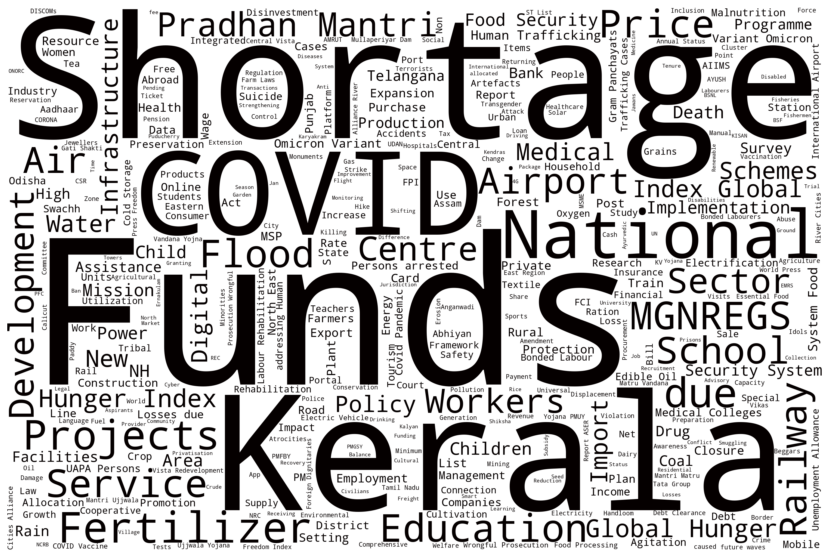

In [24]:
create_topic_wordcloud(questions[questions.party=='Indian National Congress'])
plt.savefig('1.png')

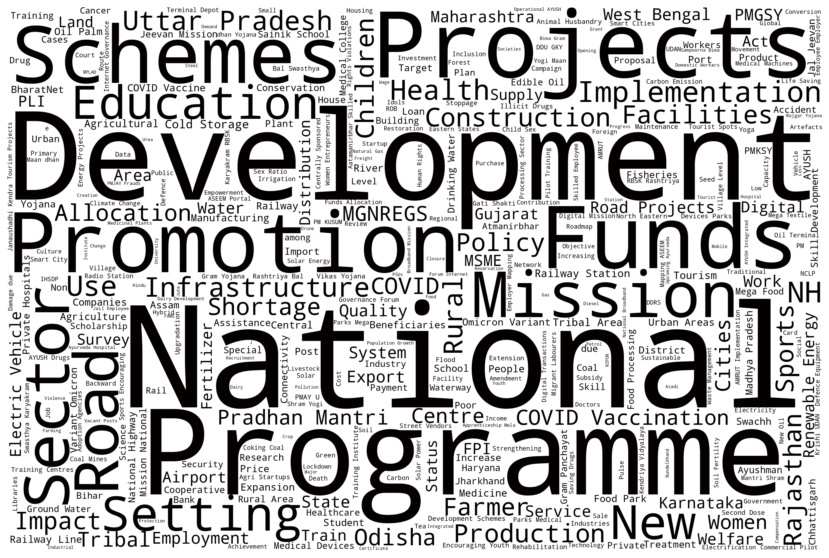

In [25]:
create_topic_wordcloud(questions[questions.party=='Bharatiya Janata Party'])
plt.savefig('2.png')

In [26]:
questions[questions.state=='Uttarakhand'].groupby('from').agg('count')

,id,topic,to,contents,date,type,party,state,constituency,constituency_type,Question Length
from,,,,,,,,,,,
"Rawat, Shri Tirath Singh",1,1,1,1,1,1,1,1,1,0,1
"Shah, Smt. Mala Rajya Laxmi",2,2,2,2,2,2,2,2,2,0,2
